<a href="https://colab.research.google.com/github/Mobad225/Image-Steganography/blob/main/Steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Upload the grayscale image

In [145]:
os.chdir('/content')
from google.colab import files
files.upload();

Saving grayscale.jpg to grayscale.jpg


# Get path of image with *.jpg* or *.jpeg* extension

In [146]:
os.chdir('/content')
dir = os.listdir()
img_path = ''
for i in range(len(dir)):
  if dir[i].endswith(('jpg', 'jpeg')):
      img_path = os.getcwd() + '/' + dir[i]

# Utility function to print photos

In [147]:
def print_photo(photo, cmap = 'gray', title = None):
  plt.axis('off')
  plt.title(title)
  plt.imshow(photo, cmap = plt.get_cmap(cmap))
  plt.show()
  plt.close()

# Reading the image from the path

In [148]:
os.chdir('/content')
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY);

# Printing the original image

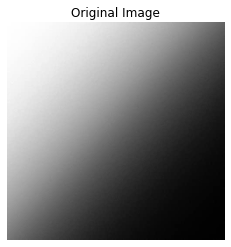

In [149]:
color_map = 'gray'
print_photo(img, cmap=color_map, title="Original Image")

# Calculating how much text can we hide

In [150]:
rows, cols = len(img), len(img[0])
bits = rows * cols * 2
print("We have", rows, "*", cols , "* 2 bits =", bits , "bits.")
print(bits, "/ 8 =", bits // 8, "bytes or characters.")

We have 500 * 500 * 2 bits = 500000 bits.
500000 / 8 = 62500 bytes or characters.


# Reading text that will be hidden

In [151]:
# Upload text file (Call it text.txt)
files.upload();
text_file = "/content/text.txt"
text_file = open(text_file, "r")
text = text_file.read()

Saving text.txt to text.txt


In [152]:
# Insert text here
# text = input();

In [153]:
text += "xx" ## As a delimiter

# Encoding Phase

## Function that takes a character and returns 4 pairs of 2 bits

In [154]:
# Complexity O(1)  - 8 Operations.
def encode_char(c):
  ascii = ord(c)
  total = ""
  for i in range(7, -1, -1):
    if (1<<i) & ascii:
      total += '1'
    else:
      total += '0'
  ret = []
  for i in range(4):
    first = total[2 * i]
    second = total[2 * i + 1]
    curr_val = 0
    if first == '1':
      curr_val += 2
    if second == '1':
      curr_val += 1
    ret.append(curr_val)
  return ret 

## Encoding the input text

In [155]:
# Complexity O(n) where n is length of text to hide

ls_encode = [] # Stores lists of 4 2-bit pairs.
for i in range(len(text)):
  ls_encode.append(encode_char(text[i]))

# Flattening the list.
flat_list_encode = [item for sublist in ls_encode for item in sublist]

print("We will only need to modify the 2 least significant bits of", len(flat_list_encode), "pixels")
print("The number of pixels we can edit = ", rows * cols)

We will only need to modify the 2 least significant bits of 151556 pixels
The number of pixels we can edit =  250000


## Embedding encoded bits in a copy of the image

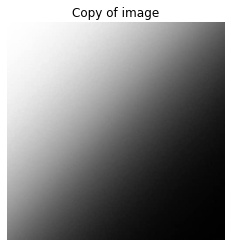

In [156]:
img_copy = np.copy(img)
print_photo(img_copy, cmap='gray', title='Copy of image')

In [157]:
# Complexity O(n) where n is length of text to hide

# Mask should be 11111100 -> 252
mask = 252
rows, cols = len(img_copy), len(img_copy[0])
for i in range(len(flat_list_encode)):
  x = i // cols
  y = i % cols
  # print('mask to add -> ', flat_list_encode[i])
  # print('old dig -> ', '{:08b}'.format(img_copy[x][y]))
  img_copy[x][y] &= mask
  img_copy[x][y] |= flat_list_encode[i]
  # print('old dig -> ', '{:08b}'.format(img_copy[x][y]))
  # print("~~~~")

## The photo with embedded message

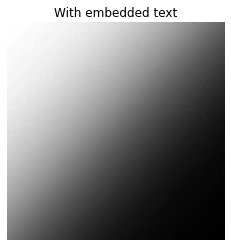

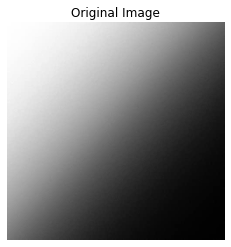

In [158]:
print_photo(img_copy, title='With embedded text')
print_photo(img, title='Original Image')

# Getting the difference between the photos

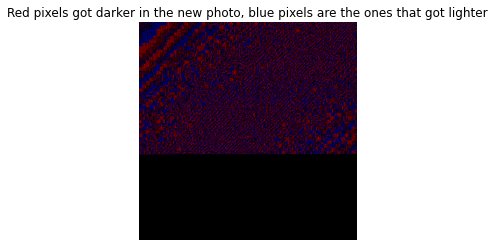

In [159]:
const = 63
img_diff = np.zeros((rows, cols, 3))
for i in range(rows):
  for j in range(cols):
    if img[i][j] > img_copy[i][j]:
      img_diff[i][j][0] = (img[i][j] - img_copy[i][j]) * const
    if img[i][j] < img_copy[i][j]:
      img_diff[i][j][2] = (img_copy[i][j] - img[i][j]) * const

img_diff = img_diff.astype(int)
print_photo(img_diff, title='Red pixels got darker in the new photo, blue pixels are the ones that got lighter')
# The black part means the pixels werent changed at all. ie. all text was already hidden

# Decoding Phase

## Function to return 2 least significant bits in a character

In [160]:
def decode_char(c, bits = 2):
  ls = []
  for i in range(bits - 1, -1, -1):
    if (1<<i & c):
      ls.append(1)
    else:
      ls.append(0)
  return ls

## Decoding pixels in the image

In [161]:
%time
img_encoded = np.copy(img_copy)
rows, cols = len(img_encoded), len(img_encoded[0])
ls_decode = [] # Stores lists of 2 bits each
for i in range(rows):
  for j in range(cols):
    ls_decode.append(decode_char(img_encoded[i][j], 2))
flat_list_decode = [item for sublist in ls_decode for item in sublist]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


## Understanding the text from the binary list

In [162]:
# As we read 8-bit characters, will append 1s until a multiple of 8
#while len(flat_list_decode) % 8:
#  flat_list_decode.append(1)

text_final = ''
buffer, cnt_x = 0, 0

for i in range(len(flat_list_decode)):
  if i and (i % 8 == 0):
    text_final += chr(buffer)
    #print(buffer, chr(buffer))
    if chr(buffer) == 'x':
      cnt_x += 1
    else:
      cnt_x = 0
    if cnt_x == 2:
      break 
    buffer = 0
  buffer *= 2
  buffer += flat_list_decode[i]

text_final = text_final[:-2]

In [163]:
with open('/content/output.txt', 'w') as writefile:
    writefile.write(text_final)

In [164]:
import filecmp
correct = filecmp.cmp('text.txt', 'output.txt', shallow=False)
print('Steganography is correct : ', correct)

Steganography is correct :  True
